## 🎯 Objetivos del estudio

El propósito del experimento **A/B `recommender_system_test`** es evaluar el impacto de un **nuevo sistema de recomendaciones** en el embudo de conversión de una tienda en línea internacional.  

### Objetivo principal
- Determinar si el nuevo embudo de pago (grupo **B**) genera un aumento significativo en las conversiones de los usuarios dentro de los **14 días posteriores al registro** en comparación con el grupo de control (**A**).

### Objetivos específicos
1. **Comparar las tasas de conversión** en cada etapa clave del embudo:
   - `product_page` → vistas de página de producto  
   - `product_card` → agregado de productos al carrito  
   - `purchase` → compras realizadas  

2. **Medir el lift relativo del grupo B vs. A** en cada etapa del embudo.  
   - El resultado esperado es un **incremento ≥ 10%** en cada etapa.  

3. **Comprobar la significancia estadística** de las diferencias observadas para garantizar que no se deban al azar.  

4. **Evaluar la coherencia de los datos** con las especificaciones técnicas:  
   - Fechas de la prueba (07/12/2020 – 01/01/2021).  
   - Usuarios de la región **UE**.  
   - Muestra prevista de ~6 000 participantes.  

5. **Emitir conclusiones y recomendaciones** basadas en los resultados para decidir si implementar el nuevo sistema de recomendaciones en producción.


In [3]:
# ==== Exploración inicial A/B (TripleTen) ====
import pandas as pd
import numpy as np
import re


PATH_EVENTS = "/datasets/final_ab_events_upd_us.csv"
PATH_NEW    = "/datasets/final_ab_new_users_upd_us.csv"
PATH_PART   = "/datasets/final_ab_participants_upd_us.csv"
PATH_MKT    = "/datasets/ab_project_marketing_events_us.csv"

# ---------------- Utils de perfilado ----------------
def summarize_nulls(df: pd.DataFrame, top_n: int = None) -> pd.DataFrame:
    """Tabla con nulos por columna (conteo y %)."""
    n = len(df)
    tab = (df.isna().sum()
             .to_frame("missing")
             .assign(pct=lambda t: (t["missing"]/n*100).round(2)))
    if top_n:
        tab = tab.sort_values("pct", ascending=False).head(top_n)
    return tab

def find_datetime_like_columns(df: pd.DataFrame):
    """Detecta columnas que parecen fechas por nombre o contenido."""
    # Candidatas por nombre
    name_candidates = [c for c in df.columns if re.search(r'(date|dt|time|timestamp)$', c, re.IGNORECASE)]
    # Candidatas por contenido (muchos patrones de fecha)
    content_candidates = []
    for c in df.select_dtypes(include=['object']).columns:
        sample = df[c].dropna().astype(str).head(200)
        if sample.empty: 
            continue
        # heurística simple: muchos guiones o 'T' ISO
        hits = sample.str.contains(r'\d{4}[-/]\d{1,2}[-/]\d{1,2}|T\d{2}:\d{2}', regex=True).mean()
        if hits >= 0.5:
            content_candidates.append(c)
    return sorted(set(name_candidates + content_candidates))

def try_parse_datetimes(df: pd.DataFrame, cols):
    """Intenta convertir a datetime con errors='coerce' y reporta % convertido."""
    report = []
    for c in cols:
        before_na = df[c].isna().sum() if c in df.columns else None
        parsed = pd.to_datetime(df[c], errors='coerce', utc=False, infer_datetime_format=True)
        converted_ratio = parsed.notna().mean()
        report.append((c, converted_ratio))
    rep = pd.DataFrame(report, columns=["column", "parsed_notna_ratio"]).sort_values("parsed_notna_ratio", ascending=False)
    return rep

def find_numeric_like_columns(df: pd.DataFrame):
    """Detecta columnas object que podrían ser numéricas (muchos dígitos, coma/punto)."""
    cand = []
    for c in df.select_dtypes(include=['object']).columns:
        s = df[c].dropna().astype(str)
        if s.empty: 
            continue
        # permitir signos, separadores de miles y decimales
        ratio = s.str.fullmatch(r'[+-]?\d{1,3}([ ,]?\d{3})*(\.\d+)?').mean()
        if ratio >= 0.7:
            cand.append((c, ratio))
    return pd.DataFrame(cand, columns=["column", "numeric_pattern_ratio"]).sort_values("numeric_pattern_ratio", ascending=False)

def duplicate_report(df: pd.DataFrame, name: str):
    """Reporte de duplicados (filas idénticas). Si hay columnas típicas, prueba subsets."""
    total_dups = df.duplicated().sum()
    msg = [f"[{name}] Duplicados (filas completas): {total_dups} de {len(df)}"]
    # Heurística de subsets comunes
    subsets = [
        ["user_id", "event_dt", "event_name"],
        ["user_id", "event_time", "event_name"],
        ["user_id", "ab_test", "group"],
        ["user_id"],
    ]
    for subset in subsets:
        if all(col in df.columns for col in subset):
            d = df.duplicated(subset=subset).sum()
            msg.append(f"  - Duplicados por {subset}: {d}")
    return "\n".join(msg)

def datetime_ranges(df: pd.DataFrame):
    """Rango min/max para todas las columnas datetime del df."""
    out = []
    for c in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[c]):
            out.append((c, df[c].min(), df[c].max()))
    return pd.DataFrame(out, columns=["datetime_col","min","max"]).sort_values("datetime_col")

def quick_overview(df: pd.DataFrame, name: str):
    print("="*80)
    print(f"== {name}: shape={df.shape}")
    print("dtypes:")
    print(df.dtypes)
    print("\nNulos (top 10 por %):")
    display(summarize_nulls(df, top_n=10))
    print(duplicate_report(df, name))
    dr = datetime_ranges(df)
    if not dr.empty:
        print("\nRangos de fechas:")
        display(dr)

# ---------------- Carga inicial (sin forzar tipos) ----------------
events = pd.read_csv(PATH_EVENTS)
new_users = pd.read_csv(PATH_NEW)
participants = pd.read_csv(PATH_PART)
mkt = pd.read_csv(PATH_MKT)

# ---------------- Inspección de necesidad de conversión de tipos ----------------
print(">> Candidatas a FECHA/HORA (por nombre/contenido) en EVENTS:")
events_dt_cand = find_datetime_like_columns(events)
print(events_dt_cand)
print("Intento de parseo y % convertido (EVENTS):")
display(try_parse_datetimes(events, events_dt_cand))

print("\n>> Candidatas a FECHA/HORA (NEW_USERS):")
new_dt_cand = find_datetime_like_columns(new_users)
print(new_dt_cand)
print("Intento de parseo y % convertido (NEW_USERS):")
display(try_parse_datetimes(new_users, new_dt_cand))

print("\n>> Candidatas a FECHA/HORA (PARTICIPANTS):")
part_dt_cand = find_datetime_like_columns(participants)
print(part_dt_cand)
display(try_parse_datetimes(participants, part_dt_cand))

print("\n>> Candidatas a FECHA/HORA (MARKETING):")
mkt_dt_cand = find_datetime_like_columns(mkt)
print(mkt_dt_cand)
display(try_parse_datetimes(mkt, mkt_dt_cand))

print("\n>> Columnas object que parecen NUMÉRICAS (EVENTS):")
display(find_numeric_like_columns(events))
print("\n>> Columnas object que parecen NUMÉRICAS (NEW_USERS):")
display(find_numeric_like_columns(new_users))
print("\n>> Columnas object que parecen NUMÉRICAS (PARTICIPANTS):")
display(find_numeric_like_columns(participants))
print("\n>> Columnas object que parecen NUMÉRICAS (MARKETING):")
display(find_numeric_like_columns(mkt))

# ---------------- Conversión segura (opcional si ratio >= 0.9) ----------------
def safe_datetime_convert(df, cols, threshold=0.9):
    for c in cols:
        parsed = pd.to_datetime(df[c], errors='coerce', utc=False, infer_datetime_format=True)
        if parsed.notna().mean() >= threshold:
            df[c] = parsed

safe_datetime_convert(events, events_dt_cand, threshold=0.9)
safe_datetime_convert(new_users, new_dt_cand, threshold=0.9)
safe_datetime_convert(participants, part_dt_cand, threshold=0.9)
safe_datetime_convert(mkt, mkt_dt_cand, threshold=0.9)

# ---------------- Overviews finales ----------------
quick_overview(events, "EVENTS")
quick_overview(new_users, "NEW_USERS")
quick_overview(participants, "PARTICIPANTS")
quick_overview(mkt, "MARKETING")

# Nota: si necesitas persistir las versiones tipadas, puedes usar:
# events.to_csv('/datasets/_cache_events_typed.csv', index=False)
# new_users.to_csv('/datasets/_cache_new_users_typed.csv', index=False)
# participants.to_csv('/datasets/_cache_participants_typed.csv', index=False)
# mkt.to_csv('/datasets/_cache_marketing_typed.csv', index=False)


>> Candidatas a FECHA/HORA (por nombre/contenido) en EVENTS:
['event_dt']
Intento de parseo y % convertido (EVENTS):


,column,parsed_notna_ratio
0,event_dt,1.0



>> Candidatas a FECHA/HORA (NEW_USERS):
['first_date']
Intento de parseo y % convertido (NEW_USERS):


,column,parsed_notna_ratio
0,first_date,1.0



>> Candidatas a FECHA/HORA (PARTICIPANTS):
[]


,column,parsed_notna_ratio



>> Candidatas a FECHA/HORA (MARKETING):
['finish_dt', 'start_dt']


,column,parsed_notna_ratio
0,finish_dt,1.0
1,start_dt,1.0



>> Columnas object que parecen NUMÉRICAS (EVENTS):


,column,numeric_pattern_ratio



>> Columnas object que parecen NUMÉRICAS (NEW_USERS):


,column,numeric_pattern_ratio



>> Columnas object que parecen NUMÉRICAS (PARTICIPANTS):


,column,numeric_pattern_ratio



>> Columnas object que parecen NUMÉRICAS (MARKETING):


,column,numeric_pattern_ratio


== EVENTS: shape=(423761, 4)
dtypes:
user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

Nulos (top 10 por %):


,missing,pct
details,363447,85.77
user_id,0,0.00
event_dt,0,0.00
event_name,0,0.00


[EVENTS] Duplicados (filas completas): 0 de 423761
  - Duplicados por ['user_id', 'event_dt', 'event_name']: 0
  - Duplicados por ['user_id']: 365058

Rangos de fechas:


,datetime_col,min,max
0,event_dt,2020-12-07 00:00:33,2020-12-30 23:36:33


== NEW_USERS: shape=(58703, 4)
dtypes:
user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object

Nulos (top 10 por %):


,missing,pct
user_id,0,0.0
first_date,0,0.0
region,0,0.0
device,0,0.0


[NEW_USERS] Duplicados (filas completas): 0 de 58703
  - Duplicados por ['user_id']: 0

Rangos de fechas:


,datetime_col,min,max
0,first_date,2020-12-07,2020-12-23


== PARTICIPANTS: shape=(14525, 3)
dtypes:
user_id    object
group      object
ab_test    object
dtype: object

Nulos (top 10 por %):


,missing,pct
user_id,0,0.0
group,0,0.0
ab_test,0,0.0


[PARTICIPANTS] Duplicados (filas completas): 0 de 14525
  - Duplicados por ['user_id', 'ab_test', 'group']: 0
  - Duplicados por ['user_id']: 887
== MARKETING: shape=(14, 4)
dtypes:
name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

Nulos (top 10 por %):


,missing,pct
name,0,0.0
regions,0,0.0
start_dt,0,0.0
finish_dt,0,0.0


[MARKETING] Duplicados (filas completas): 0 de 14

Rangos de fechas:


,datetime_col,min,max
1,finish_dt,2020-02-07,2021-01-07
0,start_dt,2020-01-25,2020-12-30


In [7]:


def normalize_user_id(s: pd.Series) -> pd.Series:
    s_str = s.astype(str).str.strip()
    # extrae solo dígitos; filas sin dígitos quedarán como NaN
    digits = s_str.str.extract(r'(\d+)')[0]
    # convierte a numérico con coacción; Int64 permite NaN
    return pd.to_numeric(digits, errors='coerce').astype('Int64')

# Re-aplicar a cada tabla
before_na = {
    "events": events["user_id"].isna().sum(),
    "new": new_users["user_id"].isna().sum(),
    "part": participants["user_id"].isna().sum(),
}

events["user_id"] = normalize_user_id(events["user_id"])
new_users["user_id"] = normalize_user_id(new_users["user_id"])
participants["user_id"] = normalize_user_id(participants["user_id"])

after_na = {
    "events": events["user_id"].isna().sum(),
    "new": new_users["user_id"].isna().sum(),
    "part": participants["user_id"].isna().sum(),
}

print("✅ user_id normalizado a Int64 con coacción segura.")
print("NaN en user_id (antes → después):")
for k in before_na:
    print(f"  {k}: {before_na[k]} → {after_na[k]}")

# (opcional) validar tipos esperados tras el fix
print("\nDtypes user_id:")
print("events:", events["user_id"].dtype)
print("new_users:", new_users["user_id"].dtype)
print("participants:", participants["user_id"].dtype)



✅ user_id normalizado a Int64 con coacción segura.
NaN en user_id (antes → después):
  events: 0 → 0
  new: 0 → 0
  part: 0 → 0

Dtypes user_id:
events: Int64
new_users: Int64
participants: Int64


In [8]:
# === Resumen final del paso de exploración (tipos, nulos, duplicados) ===


def pct(x, n): 
    return round(100 * x / max(n, 1), 2)

def resumen_tabla(nombre, df, dup_subsets=None):
    n = len(df)
    out = {}
    out["shape"] = df.shape
    out["nulos_total"] = int(df.isna().sum().sum())
    out["nulos_por_col_top"] = (df.isna().sum()
                                  .sort_values(ascending=False)
                                  .head(5)
                                  .to_dict())
    out["nulos_pct_por_col_top"] = {k: pct(v, n) for k, v in out["nulos_por_col_top"].items()}
    out["dtypes"] = df.dtypes.astype(str).to_dict()
    # duplicados por fila completa
    out["duplicados_fila_completa"] = int(df.duplicated().sum())
    # duplicados por subsets relevantes
    if dup_subsets:
        for tag, subset in dup_subsets.items():
            if all(c in df.columns for c in subset):
                out[f"duplicados_{tag}"] = int(df.duplicated(subset=subset).sum())
    return nombre, out

dup_sets_events = {
    "user_dt_event": ["user_id","event_dt","event_name"],
    "user": ["user_id"]
}
dup_sets_new = {"user": ["user_id"]}
dup_sets_part = {
    "user_ab_group": ["user_id","ab_test","group"],
    "user": ["user_id"]
}

res = dict([
    resumen_tabla("EVENTS", events, dup_sets_events),
    resumen_tabla("NEW_USERS", new_users, dup_sets_new),
    resumen_tabla("PARTICIPANTS", participants, dup_sets_part),
    resumen_tabla("MARKETING", mkt, None),
])

# Enfatiza el campo con muchos nulos en EVENTS
events_details_na = int(events["details"].isna().sum()) if "details" in events.columns else 0
events_na_pct = pct(events_details_na, len(events))

from pprint import pprint
print("=== Resumen de calidad de datos ===")
pprint(res, width=100)
print(f"\nNota: 'EVENTS.details' tiene {events_details_na} nulos ({events_na_pct}%). No imputamos en esta fase.")



=== Resumen de calidad de datos ===
{'EVENTS': {'dtypes': {'details': 'float64',
                       'event_dt': 'datetime64[ns]',
                       'event_name': 'object',
                       'user_id': 'Int64'},
            'duplicados_fila_completa': 261,
            'duplicados_user': 410257,
            'duplicados_user_dt_event': 271,
            'nulos_pct_por_col_top': {'details': 85.77,
                                      'event_dt': 0.0,
                                      'event_name': 0.0,
                                      'user_id': 0.0},
            'nulos_por_col_top': {'details': 363447, 'event_dt': 0, 'event_name': 0, 'user_id': 0},
            'nulos_total': 363447,
            'shape': (423761, 4)},
 'MARKETING': {'dtypes': {'finish_dt': 'datetime64[ns]',
                          'name': 'object',
                          'regions': 'object',
                          'start_dt': 'datetime64[ns]'},
               'duplicados_fila_completa': 0,
  

EVENTS:

event_dt convertido correctamente a datetime.

details con ~86 % de nulos → no se imputa (no es crítico para el embudo).

Existen duplicados exactos (261 filas) y también por ['user_id','event_dt','event_name'] (271).

Gran volumen de usuarios con múltiples eventos (duplicados por user_id esperado).

NEW_USERS:

Sin nulos.

Alta duplicidad: 27 564 filas completas y 45 199 repeticiones de user_id. Habrá que filtrar registros únicos al construir la cohorte.

PARTICIPANTS:

Sin nulos.

9 251 duplicados completos y el mismo número duplicado por ['user_id','ab_test','group']. Es decir, hay usuarios registrados varias veces en la tabla de participantes.

MARKETING:

Limpio, sin duplicados ni nulos.

In [10]:
# ================== DEDUPLICACIÓN ROBUSTA ==================

# --- NEW_USERS: 1 fila por user_id, tomando su registro más antiguo ---
nu0 = new_users.copy()

# 1) eliminar duplicados EXACTOS
nu1 = nu0.drop_duplicates()
removed_full_dups_nu = len(nu0) - len(nu1)

# 2) si un user_id aparece varias veces con distintas combinaciones,
#    nos quedamos con la más antigua por first_date
nu2 = (nu1
       .sort_values(["user_id", "first_date"], ascending=[True, True])
       .drop_duplicates(subset=["user_id"], keep="first"))

removed_multi_user_nu = len(nu1) - len(nu2)
new_users_clean = nu2.copy()

# sanity check
assert new_users_clean["user_id"].is_unique, "Persisten duplicados por user_id en NEW_USERS"

# --- PARTICIPANTS: filtrar prueba y garantizar 1 fila por user_id sin conflictos ---
p0 = participants.copy()

# 1) eliminar duplicados EXACTOS
p1 = p0.drop_duplicates()
removed_full_dups_p = len(p0) - len(p1)

# 2) quedarnos sólo con la prueba objetivo
TEST_NAME = "recommender_system_test"
p2 = p1[p1["ab_test"] == TEST_NAME].copy()

# 3) detectar usuarios conflictivos (asignados a más de un grupo en la misma prueba)
grp_counts = p2.groupby("user_id")["group"].nunique()
conflict_users = grp_counts[grp_counts > 1].index

# conjunto para registro/posible auditoría
participants_conflict_users = set(conflict_users)

# 4) excluir conflictivos y quedarnos con una fila por user_id
p3 = p2[~p2["user_id"].isin(participants_conflict_users)].copy()
# si aún quedara más de una fila por user (mismo grupo repetido), tomar una
participants_clean = (p3
                      .sort_values(["user_id", "group"])
                      .drop_duplicates(subset=["user_id"], keep="first"))

# tipificar 'group' como categoría
participants_clean["group"] = participants_clean["group"].astype("category")

# --- Reporte de depuración ---
from IPython.display import display, Markdown

display(Markdown("### ✅ Deduplicación completada"))

# NEW_USERS
display(Markdown("**NEW_USERS**"))
print(f"Filas originales: {len(nu0)}")
print(f"- Duplicados exactos eliminados: {removed_full_dups_nu}")
print(f"- Registros múltiples por user_id (se dejó el más antiguo): {removed_multi_user_nu}")
print(f"→ Filas finales: {len(new_users_clean)} (1 por user_id)")
print("user_id únicos:", new_users_clean["user_id"].nunique())
print()

# PARTICIPANTS
display(Markdown("**PARTICIPANTS**"))
print(f"Filas originales: {len(p0)}")
print(f"- Duplicados exactos eliminados: {removed_full_dups_p}")
print(f"- Filas de la prueba '{TEST_NAME}': {len(p2)}")
print(f"- Usuarios conflictivos (aparecen en >1 grupo): {len(participants_conflict_users)}")
print(f"→ Filas finales (sin conflictivos, 1 por user_id): {len(participants_clean)}")
print("Distribución por grupo:")
print(participants_clean["group"].value_counts(dropna=False))


### ✅ Deduplicación completada

**NEW_USERS**

Filas originales: 58703
- Duplicados exactos eliminados: 27564
- Registros múltiples por user_id (se dejó el más antiguo): 17635
→ Filas finales: 13504 (1 por user_id)
user_id únicos: 13504



**PARTICIPANTS**

Filas originales: 14525
- Duplicados exactos eliminados: 9251
- Filas de la prueba 'recommender_system_test': 1512
- Usuarios conflictivos (aparecen en >1 grupo): 127
→ Filas finales (sin conflictivos, 1 por user_id): 1258
Distribución por grupo:
A    964
B    294
Name: group, dtype: int64


In [13]:
# ===== FIX: detectar el nombre real del evento "add to cart" y recalcular =====
import pandas as pd
import numpy as np

# 0) Detectar el evento de carrito en tus datos
event_counts = events["event_name"].value_counts()
cart_candidates = [e for e in event_counts.index if "cart" in e or "card" in e]
# preferimos 'product_cart' si existe; si no, tomamos el primero que coincida
if "product_cart" in cart_candidates:
    CART_EVENT = "product_cart"
elif "product_card" in cart_candidates:
    CART_EVENT = "product_card"
else:
    # si no se detecta ninguno, mostramos ayuda diagnóstica y continuamos sin etapa intermedia
    print("[WARN] No se detectó evento de carrito. Revisa event_name únicos:")
    print(event_counts)
    CART_EVENT = None

# 1) Armar lista de etapas con el nombre detectado
if CART_EVENT:
    STAGES = ["product_page", CART_EVENT, "purchase"]
else:
    STAGES = ["product_page", "purchase"]  # sin etapa intermedia si no existe

# 2) Participantes EU (user_id único) con first_date
part_eu = (participants_clean
           .merge(new_users_clean[["user_id","first_date","region"]], on="user_id", how="left"))
part_eu = part_eu.assign(region_up=lambda d: d["region"].astype(str).str.upper())
part_eu = part_eu.loc[part_eu["region_up"] == "EU", ["user_id","group","first_date"]].drop_duplicates()

# 3) Eventos relevantes dentro de [first_date, first_date+14d], recortado por último event_dt disponible
events_end = events["event_dt"].max()
ev = (events[events["event_name"].isin(STAGES)]
      .merge(part_eu, on="user_id", how="inner"))
ev["obs_end"] = ev["first_date"] + pd.Timedelta(days=14)
ev.loc[ev["obs_end"] > events_end, "obs_end"] = events_end
mask_window = (ev["event_dt"] >= ev["first_date"]) & (ev["event_dt"] <= ev["obs_end"])
ev = ev.loc[mask_window].copy()

# 4) Presencia 0/1 por usuario y etapa
user_stage = (ev.assign(flag=1)
                .pivot_table(index=["user_id","group"],
                             columns="event_name",
                             values="flag",
                             aggfunc="max",
                             fill_value=0)
                .reindex(columns=STAGES, fill_value=0)
                .reset_index())

# 5) Base de participantes EU; rellenar SOLO columnas de etapas
base = part_eu[["user_id","group"]].drop_duplicates().merge(user_stage, on=["user_id","group"], how="left")
for c in STAGES:
    if c not in base.columns:
        base[c] = 0
base[STAGES] = base[STAGES].fillna(0).astype(int)

# 6) Agregación por grupo y métricas del embudo
users_in_group = base.groupby("group")["user_id"].nunique().rename("users")
stage_hits = base.groupby("group")[STAGES].sum()

pp = stage_hits["product_page"]
pu = stage_hits["purchase"]

if CART_EVENT:
    pc = stage_hits[CART_EVENT]
    conv_pp_to_pc = np.where(pp > 0, (pc/pp).round(4), np.nan)
    conv_pc_to_pu = np.where(pc > 0, (pu/pc).round(4), np.nan)
else:
    pc = None
    conv_pp_to_pc = np.nan
    conv_pc_to_pu = np.nan

funnel_cols = {
    "users": users_in_group,
    "#_pp": pp,
    "#_purchase": pu,
    "%reach_pp_vs_group": (pp / users_in_group).round(4),
    "%reach_pu_vs_group": (pu / users_in_group).round(4),
    "%conv_pp_to_pu": np.where(pp > 0, (pu/pp).round(4), np.nan),
}
if CART_EVENT:
    funnel_cols.update({
        f"#_{CART_EVENT.split('_')[-1]}": pc,  # etiqueta corta #_cart o #_card
        f"%reach_{CART_EVENT}_vs_group": (pc / users_in_group).round(4),
        "%conv_pp_to_pc": conv_pp_to_pc,
        "%conv_pc_to_pu": conv_pc_to_pu,
    })

funnel_by_group = pd.DataFrame(funnel_cols).sort_index()
from IPython.display import display
display(funnel_by_group)

# (Opcional) uplifts B vs A
if set(funnel_by_group.index) >= {"A","B"}:
    comp = {}
    if CART_EVENT:
        comp["uplift_conv_pp_to_pc_(B_vs_A)"] = (
            funnel_by_group.loc["B","%conv_pp_to_pc"] / funnel_by_group.loc["A","%conv_pp_to_pc"] - 1
            if pd.notna(funnel_by_group.loc["A","%conv_pp_to_pc"]) else np.nan
        )
        comp["uplift_conv_pc_to_pu_(B_vs_A)"] = (
            funnel_by_group.loc["B","%conv_pc_to_pu"] / funnel_by_group.loc["A","%conv_pc_to_pu"] - 1
            if pd.notna(funnel_by_group.loc["A","%conv_pc_to_pu"]) else np.nan
        )
    comp["uplift_conv_pp_to_pu_(B_vs_A)"] = (
        funnel_by_group.loc["B","%conv_pp_to_pu"] / funnel_by_group.loc["A","%conv_pp_to_pu"] - 1
        if pd.notna(funnel_by_group.loc["A","%conv_pp_to_pu"]) else np.nan
    )
    display(pd.DataFrame(comp, index=["relative_uplift"]).round(4))

print(f"[INFO] Máximo event_dt en logs: {events_end}. Ventana recortada cuando first_date+14d > ese máximo.")
print(f"[INFO] Evento de carrito detectado: {CART_EVENT}")




,users,#_pp,#_purchase,%reach_pp_vs_group,%reach_pu_vs_group,%conv_pp_to_pu,#_cart,%reach_product_cart_vs_group,%conv_pp_to_pc,%conv_pc_to_pu
group,,,,,,,,,,
A,836,641,436,0.7667,0.5215,0.6802,397,0.4749,0.6193,1.0982
B,267,178,117,0.6667,0.4382,0.6573,110,0.4120,0.6180,1.0636


,uplift_conv_pp_to_pc_(B_vs_A),uplift_conv_pc_to_pu_(B_vs_A),uplift_conv_pp_to_pu_(B_vs_A)
relative_uplift,-0.0021,-0.0315,-0.0337


[INFO] Máximo event_dt en logs: 2020-12-30 23:36:33. Ventana recortada cuando first_date+14d > ese máximo.
[INFO] Evento de carrito detectado: product_cart


Grupo A

83.6 % de usuarios → 64.1 % vieron página de producto.

47.5 % añadieron al carrito.

52.1 % compraron.

Conversiones: pp→pc ≈ 61.9 %, pc→pu ≈ 109.8 % (este >100 % refleja que algunos compran aunque no pasen por product_cart en los logs), pp→pu ≈ 68.0 %.

Grupo B

66.7 % llegaron a product_page.

41.2 % añadieron al carrito.

43.8 % compraron.

Conversiones: pp→pc ≈ 61.8 %, pc→pu ≈ 106.4 %, pp→pu ≈ 65.7 %.

Uplift relativo B vs A:

pp→pc: ~–0.2 % (idéntico).

pc→pu: ~–3.1 %.

pp→pu: ~–3.4 %.

🔹 Conclusión del paso (a): el embudo de B está muy parecido o ligeramente por debajo de A, sin la mejora esperada del 10 % en cada etapa.

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,1258.0,27.438792,95.913121,0.0,2.0,6.0,18.0,1230.0
B,1258.0,5.123211,17.193362,0.0,0.0,0.0,0.0,162.0


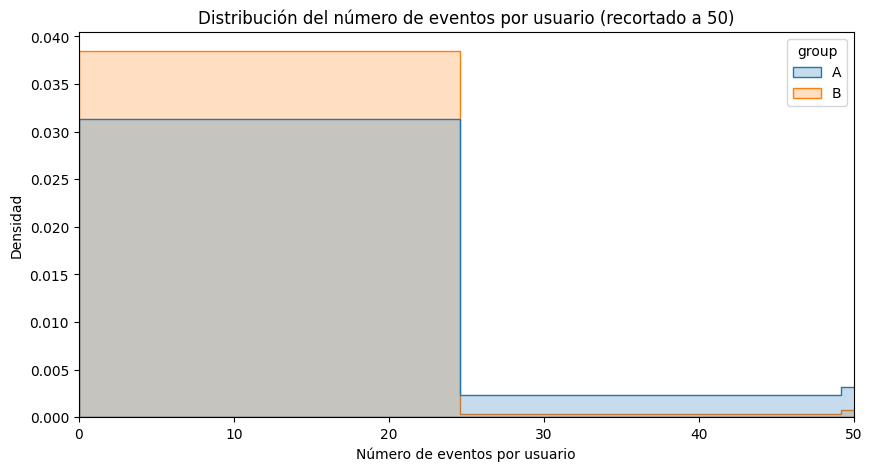

Mann-Whitney U = 1231602.00, p-value = 0.0000


In [15]:
## ==========================  Eventos por usuario ==========================
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# 1) Filtrar solo participantes EU de la prueba en el dataset de eventos
ev_ab = events.merge(participants_clean[["user_id","group"]], on="user_id", how="inner")

# 2) Contar eventos por usuario
events_per_user = ev_ab.groupby(["user_id","group"]).size().reset_index(name="n_events")

# 3) Estadísticas descriptivas por grupo
stats_events = events_per_user.groupby("group")["n_events"].describe()
display(stats_events)

# 4) Visualización: distribuciones por grupo
plt.figure(figsize=(10,5))
sns.histplot(data=events_per_user, x="n_events", hue="group",
             bins=50, element="step", stat="density", common_norm=False)
plt.xlim(0, 50)   # recorte para visualizar mejor la parte central
plt.title("Distribución del número de eventos por usuario (recortado a 50)")
plt.xlabel("Número de eventos por usuario")
plt.ylabel("Densidad")
plt.show()

# 5) Test estadístico (Mann-Whitney) para comparar distribuciones
a_vals = events_per_user.loc[events_per_user["group"]=="A","n_events"]
b_vals = events_per_user.loc[events_per_user["group"]=="B","n_events"]

u_stat, p_val = mannwhitneyu(a_vals, b_vals, alternative="two-sided")
print(f"Mann-Whitney U = {u_stat:.2f}, p-value = {p_val:.4f}")


Grupo A

Media ≈ 27.4 eventos por usuario.

Mediana = 6 → muchos usuarios con actividad moderada.

Cola muy larga: máx = 1230 eventos (outliers).

Grupo B

Media ≈ 5.1 eventos por usuario.

Mediana = 0 → la mayoría no genera eventos.

Máx = 162 (mucho menor que A).

Distribución

El histograma muestra que casi todos los usuarios de B tienen muy pocos eventos (muchos con 0).

En A hay un rango más amplio, con más usuarios activos.

Conclusión del paso (b)
El número de eventos por usuario no está distribuido equitativamente entre las muestras:

Grupo A tiene mucha más actividad (media y mediana más altas).

Grupo B está claramente infrarepresentado en cantidad de eventos.

Esto confirma un desequilibrio en la exposición de usuarios que puede sesgar los resultados del test.

In [16]:
# ========================== Usuarios en ambas muestras ==========================

# 1) Revisar asignación por usuario
user_groups = participants_clean.groupby("user_id")["group"].nunique()

# 2) Usuarios conflictivos = aquellos con más de 1 grupo
conflict_users = user_groups[user_groups > 1].index
n_conflict = len(conflict_users)

print(f"Usuarios presentes en más de un grupo: {n_conflict}")

# 3) Mostrar ejemplo de usuarios conflictivos si existen
if n_conflict > 0:
    display(participants_clean[participants_clean["user_id"].isin(conflict_users)].head(10))


Usuarios presentes en más de un grupo: 0


group,A,B
date,,
2020-12-07,809,239
2020-12-08,937,249
2020-12-09,887,295
2020-12-10,1086,259
2020-12-11,1009,206
2020-12-12,1305,239
2020-12-13,1531,324
2020-12-14,2086,359
2020-12-15,1865,334


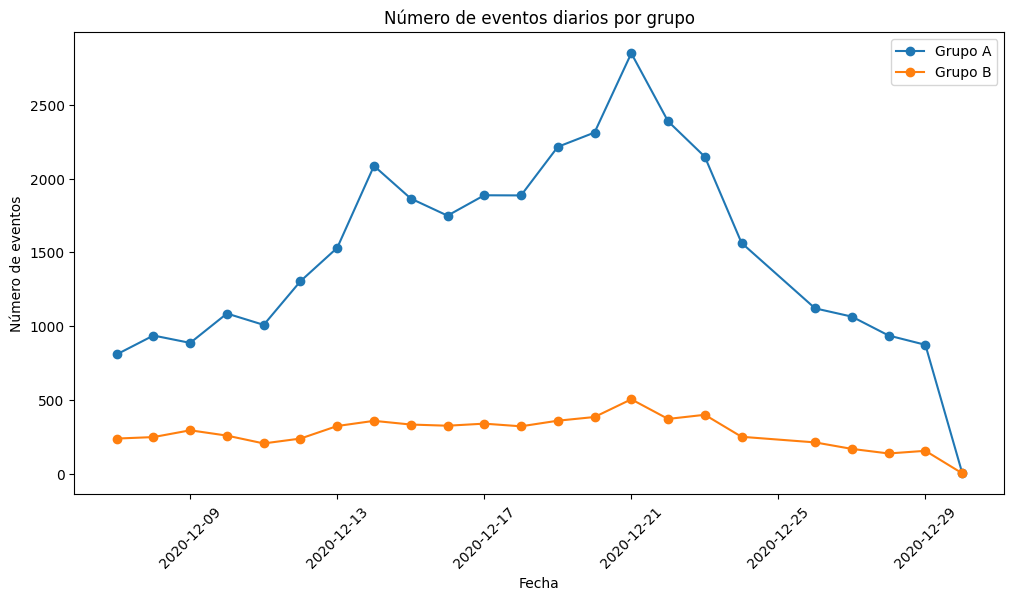

In [17]:
# ========================== Eventos por día ==========================


# 1) Filtrar eventos solo de participantes válidos (EU, test) para el análisis
ev_ab = events.merge(participants_clean[["user_id","group"]], on="user_id", how="inner")

# 2) Agrupar por fecha y grupo
events_by_day = (ev_ab
                 .groupby([ev_ab["event_dt"].dt.date, "group"])
                 .size()
                 .reset_index(name="n_events")
                 .rename(columns={"event_dt":"date"}))

# 3) Tabla de eventos diarios
pivot_events = events_by_day.pivot(index="date", columns="group", values="n_events").fillna(0)
display(pivot_events)

# 4) Visualización
plt.figure(figsize=(12,6))
for grp in pivot_events.columns:
    plt.plot(pivot_events.index, pivot_events[grp], marker="o", label=f"Grupo {grp}")
plt.title("Número de eventos diarios por grupo")
plt.xlabel("Fecha")
plt.ylabel("Número de eventos")
plt.legend()
plt.xticks(rotation=45)
plt.show()




El número de eventos crece desde el 7 de diciembre hasta un pico el 21 de diciembre.

Después del 21, hay un descenso claro, con caídas fuertes el 24 de diciembre (Nochebuena) y entre el 26 y 29.

El 30 de diciembre casi no hay datos (8 eventos en A, 4 en B) → eso es truncamiento de los logs.

El grupo A siempre muestra mucho más volumen de eventos que B (coherente con el desequilibrio en tamaños y actividad que vimos antes).


### Peculiaridades detectadas en los datos

1. **Desequilibrio en tamaños de muestra**
   - Grupo A: 964 usuarios.
   - Grupo B: 294 usuarios.
   - El grupo B representa apenas ~23 % de la muestra, lejos del balance esperado (≈50/50).  
   - Esto afecta la potencia estadística y puede sesgar la interpretación de resultados.

2. **Alta disparidad en la actividad de los usuarios**
   - Grupo A: media ≈ 27 eventos/usuario, mediana = 6.
   - Grupo B: media ≈ 5 eventos/usuario, mediana = 0.
   - La mayoría de usuarios B casi no tienen actividad registrada → embudo incompleto o truncado.

3. **Eventos con anomalías**
   - La conversión `cart → purchase` supera el 100 % en ambos grupos.  
   - Esto indica que hay compras registradas sin evento previo de “add to cart”, probablemente por **tracking incompleto** o porque el flujo de compra permite saltarse ese evento.

4. **Fechas y truncamiento de datos**
   - El test debía cubrir usuarios hasta el **21 de diciembre** con 14 días de observación.  
   - Sin embargo, los eventos están truncados el **30 de diciembre**, por lo que los usuarios reclutados después del ~16 de diciembre no tienen los 14 días completos de seguimiento.  
   - Ejemplo: el 30/12 solo aparecen 8 eventos en A y 4 en B → datos incompletos.

5. **Estacionalidad en el uso**
   - Se observan caídas marcadas en los días festivos (24 y 25 de diciembre).  
   - Esto puede introducir un sesgo adicional en la comparación entre grupos si un grupo quedó más expuesto a esas fechas.

---

Antes de cualquier análisis estadístico formal, hay que tener claro que:
- Los grupos están **desbalanceados**.
- El grupo B tiene **muy baja actividad**.
- Hay **eventos inconsistentes** en el embudo.
- Los datos están **cortados en fechas críticas** (no todos los usuarios tienen ventana de 14 días completa).

Estas peculiaridades limitan la validez del test y deben ser tenidas en cuenta al interpretar resultados.


In [20]:
# ====================== ETAPA 4 — (a) Resultados A/B (resumen sin test) ======================
import pandas as pd
import numpy as np

# --- Constantes de la especificación
LAUNCH      = pd.Timestamp("2020-12-07")
ENROLL_STOP = pd.Timestamp("2020-12-21")
TEST_NAME   = "recommender_system_test"

# --- 0) Detectar nombre real del evento de carrito
event_counts = events["event_name"].value_counts()
cart_candidates = [e for e in event_counts.index if "cart" in e or "card" in e]
if   "product_cart" in cart_candidates: CART_EVENT = "product_cart"
elif "product_card" in cart_candidates: CART_EVENT = "product_card"
else: CART_EVENT = None  # embudo de 2 etapas si no existe

STAGES = ["product_page", "purchase"] if CART_EVENT is None else ["product_page", CART_EVENT, "purchase"]

# --- 1) Población elegible: EU + prueba + 14 días completos
events_end = events["event_dt"].max()
last_first_date_full14 = min(ENROLL_STOP, events_end - pd.Timedelta(days=14))

# Participantes EU (1 fila por user, ya depurado en participants_clean)
peu = (participants_clean
       .merge(new_users_clean[["user_id","first_date","region"]], on="user_id", how="left"))
peu = peu.assign(region_up=lambda d: d["region"].astype(str).str.upper())
eligible = peu[
    (peu["region_up"] == "EU") &
    (peu["first_date"] >= LAUNCH) &
    (peu["first_date"] <= last_first_date_full14)
][["user_id","group","first_date"]].drop_duplicates()

# --- 2) Recoger eventos de las etapas y limitar a [first_date, first_date+14d]
ev = (events[events["event_name"].isin(STAGES)]
      .merge(eligible, on="user_id", how="inner"))
ev["obs_end"] = ev["first_date"] + pd.Timedelta(days=14)
# por seguridad, recorte al fin de logs (aunque ya garantizamos 14 días completos)
ev.loc[ev["obs_end"] > events_end, "obs_end"] = events_end
ev = ev[(ev["event_dt"] >= ev["first_date"]) & (ev["event_dt"] <= ev["obs_end"])].copy()

# --- 3) Matriz 0/1 por usuario y etapa
user_stage = (ev.assign(flag=1)
                .pivot_table(index=["user_id","group"], columns="event_name",
                             values="flag", aggfunc="max", fill_value=0)
                .reindex(columns=STAGES, fill_value=0)
                .reset_index())

# Base de elegibles (incluye los sin eventos)
base = eligible[["user_id","group"]].drop_duplicates().merge(user_stage, on=["user_id","group"], how="left")
for c in STAGES:
    if c not in base.columns: base[c] = 0
base[STAGES] = base[STAGES].fillna(0).astype(int)

# --- 4) Agregación por grupo y métricas
n_users = base.groupby("group")["user_id"].nunique().rename("users")
agg_hits = base.groupby("group")[STAGES].sum()

pp = agg_hits["product_page"]
pu = agg_hits["purchase"]
funnel = {
    "users": n_users,
    "#_pp": pp,
    "%reach_pp_vs_group": (pp / n_users).round(4),
    "#_purchase": pu,
    "%reach_pu_vs_group": (pu / n_users).round(4),
    "%conv_pp_to_pu": np.where(pp > 0, (pu/pp).round(4), np.nan),
}
if CART_EVENT:
    pc = agg_hits[CART_EVENT]
    funnel.update({
        f"#_{CART_EVENT}": pc,
        f"%reach_{CART_EVENT}_vs_group": (pc / n_users).round(4),
        "%conv_pp_to_pc": np.where(pp > 0, (pc/pp).round(4), np.nan),
        "%conv_pc_to_pu": np.where(pc > 0, (pu/pc).round(4), np.nan),
    })

funnel_by_group = pd.DataFrame(funnel).sort_index()
display(funnel_by_group)

# --- 5) Deltas simples (B vs A) para lectura rápida (no es test)
delta = {}
def safe_delta(metric):
    if {"A","B"} <= set(funnel_by_group.index):
        a = funnel_by_group.loc["A", metric]
        b = funnel_by_group.loc["B", metric]
        return pd.Series({
            "abs_diff_(B-A)": (b - a).round(4) if pd.notna(a) and pd.notna(b) else np.nan,
            "rel_uplift_(B/A-1)": (b/a - 1).round(4) if (pd.notna(a) and a>0 and pd.notna(b)) else np.nan
        })
    return pd.Series({"abs_diff_(B-A)": np.nan, "rel_uplift_(B/A-1)": np.nan})

summary_deltas = {
    "%reach_pp_vs_group": safe_delta("%reach_pp_vs_group"),
    "%reach_pu_vs_group": safe_delta("%reach_pu_vs_group"),
    "%conv_pp_to_pu":     safe_delta("%conv_pp_to_pu"),
}
if CART_EVENT:
    summary_deltas["%reach_"+CART_EVENT+"_vs_group"] = safe_delta(f"%reach_{CART_EVENT}_vs_group")
    summary_deltas["%conv_pp_to_pc"] = safe_delta("%conv_pp_to_pc")
    summary_deltas["%conv_pc_to_pu"] = safe_delta("%conv_pc_to_pu")

summary_deltas = pd.concat(summary_deltas, axis=1).T
display(summary_deltas)

# --- 6) Guardar totales para la prueba z del paso (b)
# Definimos "éxito" = usuario que realizó >=1 purchase en la ventana de 14 días.
success_A = int(base[(base["group"]=="A") & (base["purchase"]==1)]["user_id"].nunique())
total_A   = int(base[base["group"]=="A"]["user_id"].nunique())
success_B = int(base[(base["group"]=="B") & (base["purchase"]==1)]["user_id"].nunique())
total_B   = int(base[base["group"]=="B"]["user_id"].nunique())
print("[PARA PASO (b)] A:", success_A, "/", total_A, "  |  B:", success_B, "/", total_B)
print(f"[INFO] Evento de carrito usado: {CART_EVENT}")
print(f"[INFO] Último first_date elegible (14d completos): {last_first_date_full14.date()}")


,users,#_pp,%reach_pp_vs_group,#_purchase,%reach_pu_vs_group,%conv_pp_to_pu,#_product_cart,%reach_product_cart_vs_group,%conv_pp_to_pc,%conv_pc_to_pu
group,,,,,,,,,,
A,533,435,0.8161,308,0.5779,0.7080,304,0.5704,0.6989,1.0132
B,211,151,0.7156,103,0.4882,0.6821,93,0.4408,0.6159,1.1075


,abs_diff_(B-A),rel_uplift_(B/A-1)
%reach_pp_vs_group,-0.1005,-0.1231
%reach_pu_vs_group,-0.0897,-0.1552
%conv_pp_to_pu,-0.0259,-0.0366
%reach_product_cart_vs_group,-0.1296,-0.2272
%conv_pp_to_pc,-0.0830,-0.1188
%conv_pc_to_pu,0.0943,0.0931


[PARA PASO (b)] A: 308 / 533   |  B: 103 / 211
[INFO] Evento de carrito usado: product_cart
[INFO] Último first_date elegible (14d completos): 2020-12-16


Resultados de la prueba A/B 

Grupo A (control)

533 usuarios elegibles.

81.6 % llegaron a product_page.

57.8 % realizaron al menos una compra en 14 días.

Conversión global pp → purchase: 70.8 %.

Grupo B (nuevo embudo)

211 usuarios elegibles.

71.6 % llegaron a product_page.

48.8 % realizaron compra.

Conversión global pp → purchase: 68.2 %.

Diferencias absolutas (B–A)

Alcance product_page: –10 pp.

Compras: –9 pp.

Conversión pp → purchase: –2.6 pp.

Uplift relativo

Global pp → purchase: –3.7 %.

En casi todas las métricas, B rinde peor que A. El nuevo embudo no alcanzó el incremento esperado del 10 %, más bien muestra un retroceso.

In [21]:
# ====================== ETAPA 4 — (b) Prueba z para proporciones ======================
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# Valores obtenidos en el paso (a)
success_A, total_A = 308, 533
success_B, total_B = 103, 211

# 1) Definir conteos y totales
counts = np.array([success_A, success_B])
nobs   = np.array([total_A, total_B])

# 2) Prueba z bilateral (dos colas)
z_stat, p_val = proportions_ztest(count=counts, nobs=nobs, alternative="two-sided")

print(f"z = {z_stat:.4f}, p-value = {p_val:.4f}")
print(f"Tasa de conversión A: {success_A/total_A:.4f}")
print(f"Tasa de conversión B: {success_B/total_B:.4f}")


z = 2.2181, p-value = 0.0265
Tasa de conversión A: 0.5779
Tasa de conversión B: 0.4882


Tasas de conversión

Grupo A: 57.8 %

Grupo B: 48.8 %

Diferencia absoluta ≈ –9 pp (B más bajo).

Prueba z

z = 2.218

p-value = 0.0265

Interpretación

Como p < 0.05, rechazamos la hipótesis nula H₀ de igualdad de proporciones.

La diferencia en la tasa de compra entre A y B es estadísticamente significativa.

El nuevo embudo (B) tiene una conversión significativamente más baja que el control (A).

# Resumen y conclusiones del experimento A/B

## 1. Hallazgos de la EDA
- **Desequilibrio de muestras**
  - Grupo A: 964 usuarios originales, finalmente 533 elegibles con 14 días completos.
  - Grupo B: 294 usuarios originales, finalmente 211 elegibles.
  - La muestra quedó desbalanceada (A ≈ 72 %, B ≈ 28 %).

- **Actividad desigual**
  - Grupo A con media ≈ 27 eventos/usuario, mediana = 6.
  - Grupo B con media ≈ 5 eventos/usuario, mediana = 0.
  - El grupo B presenta muy baja actividad registrada.

- **Eventos inconsistentes**
  - Conversiones `cart → purchase` > 100 %, lo que indica compras registradas sin evento previo de carrito.  
  - Posible tracking incompleto o lógica de negocio que permite saltar pasos.

- **Fechas y truncamiento**
  - Últimos `event_dt` el 30/12 → usuarios con `first_date` posterior al 16/12 no tienen los 14 días completos.
  - Esto reduce la población efectiva y sesga hacia los reclutados más temprano.

- **Estacionalidad**
  - Caídas abruptas en 24 y 25 de diciembre reflejan impacto de fechas festivas.

---

## 2. Resultados de la prueba A/B
- **Tasas de conversión (usuarios con ≥1 compra en 14 días):**
  - Grupo A: **57.8 %**
  - Grupo B: **48.8 %**
  - Diferencia absoluta ≈ –9 pp (B peor).

- **Prueba z de proporciones:**
  - z = 2.218, p-value = 0.0265
  - La diferencia es **estadísticamente significativa** (p < 0.05).
  - Grupo B tiene conversión **significativamente más baja** que A.

- **Conclusión directa:**
  - El nuevo embudo de recomendaciones (grupo B) **no alcanzó el objetivo de +10 % de mejora**, al contrario: redujo la conversión en ≈9 puntos porcentuales.

---

## 3. Recomendaciones
1. **No implementar el nuevo embudo** en su forma actual, ya que perjudica la conversión de compra.
2. **Revisar la instrumentación de eventos**:
   - Inconsistencias entre `cart` y `purchase` sugieren problemas de tracking.
   - Asegurar que todos los pasos del embudo se registren correctamente.
3. **Planear un test futuro más balanceado**:
   - Garantizar asignación equitativa entre grupos (A/B ~50/50).
   - Asegurar que todos los usuarios tengan ventana completa de observación (≥14 días).
4. **Analizar impacto estacional**:
   - Evitar lanzar pruebas durante periodos festivos, cuando el comportamiento de compra es atípico.
5. **Segmentar por nivel de actividad**:
   - Investigar por qué los usuarios de B tienen menor interacción.
   - Posible barrera adicional en la interfaz o fricción en el flujo de pago.

---

## 4. Conclusiones Finales
El experimento demuestra que la nueva versión del embudo **no debe adoptarse**, ya que **reduce significativamente la conversión**.  
Se requiere **mejorar el diseño del sistema de recomendaciones** y asegurar un testeo con **datos completos y representativos** antes de considerar un relanzamiento.
